In [ ]:
import os 
import rk_solver_cpp
from scipy.integrate import ode
import numpy as np
import matplotlib.pyplot as plt
import SundialsPy as SP
import cantera as ct
import time
from typing import Tuple, List, Dict, Any, Optional
from tqdm import tqdm 

In [ ]:
# ============================================================================
# CHEMISTRY SETUP FUNCTIONS
# ============================================================================

def setup_combustion_chemistry(mechanism: str, fuel: str, oxidizer: str, 
                              phi: float, temperature: float, pressure: float) -> ct.Solution:
    """Set up the combustion chemistry with Cantera.
    
    Args:
        mechanism: Path to mechanism file
        fuel: Fuel species name
        oxidizer: Oxidizer mixture string
        phi: Equivalence ratio
        temperature: Initial temperature (K)
        pressure: Initial pressure (Pa)
    
    Returns:
        gas: Initialized Cantera gas object
    """
    gas = ct.Solution(mechanism)
    gas.set_equivalence_ratio(phi, fuel, oxidizer)
    gas.TPX = temperature, pressure, gas.X
    return gas

def get_initial_state(gas: ct.Solution) -> np.ndarray:
    """Get initial state vector [T, Y1, Y2, ...].
    
    Args:
        gas: Cantera gas object
    
    Returns:
        y: Initial state vector
    """
    return np.hstack([gas.T, gas.Y])

def reset_chemistry_state(gas: ct.Solution, phi: float, fuel: str, oxidizer: str, 
                         temperature: float, pressure: float) -> Tuple[ct.Solution, np.ndarray]:
    """Reset chemistry to initial conditions.
    
    Args:
        gas: Cantera gas object
        phi: Equivalence ratio
        fuel: Fuel species name
        oxidizer: Oxidizer mixture string
        temperature: Initial temperature (K)
        pressure: Initial pressure (Pa)
    
    Returns:
        gas: Reset gas object
        y: Reset state vector
    """
    gas.set_equivalence_ratio(phi, fuel, oxidizer)
    gas.TPX = temperature, pressure, gas.X
    y = np.hstack([gas.T, gas.Y])
    return gas, y

In [ ]:
# ============================================================================
# ODE SYSTEM DEFINITION
# ============================================================================

def combustion_rhs(t: float, y: np.ndarray, gas: ct.Solution, pressure: float) -> np.ndarray:
    """Right-hand side of the combustion ODE system.
    
    Args:
        t: Current time
        y: Current state vector [T, Y1, Y2, ...]
        gas: Cantera gas object
        pressure: Constant pressure
    
    Returns:
        dydt: Time derivatives [dT/dt, dY1/dt, dY2/dt, ...]
    """
    # Extract temperature and mass fractions
    T = y[0]
    Y = y[1:]
    
    # Update the gas state
    gas.TPY = T, pressure, Y
    
    # Get thermodynamic properties
    rho = gas.density_mass
    wdot = gas.net_production_rates
    cp = gas.cp_mass
    h = gas.partial_molar_enthalpies
    
    # Calculate temperature derivative (energy equation)
    dTdt = -(np.dot(h, wdot) / (rho * cp))
    
    # Calculate species derivatives (mass conservation)
    dYdt = wdot * gas.molecular_weights / rho
    
    # Combine into full derivative vector
    return np.hstack([dTdt, dYdt])

In [ ]:
# ============================================================================
# SOLVER CREATION FUNCTIONS
# ============================================================================

def create_sundials_solver(method: str, y: np.ndarray, t: float, system_size: int, rtol: float, atol: np.ndarray, 
                          gas: ct.Solution, pressure: float) -> Any:
    """Create a SUNDIALS solver.
    
    Args:
        method: Solver method ('cvode_bdf', 'cvode_adams', 'arkode_erk')
        system_size: Size of the ODE system
        rtol: Relative tolerance
        atol: Absolute tolerance array
        gas: Cantera gas object
        pressure: Constant pressure
    
    Returns:
        solver: Initialized SUNDIALS solver
    """
    if method == 'cvode_bdf':
        solver = SP.cvode.CVodeSolver(
            system_size=system_size,
            rhs_fn=lambda t, y: combustion_rhs(t, y, gas, pressure),
            iter_type=SP.cvode.IterationType.NEWTON
        )
    elif method == 'cvode_adams':
        solver = SP.cvode.CVodeSolver(
            system_size=system_size,
            rhs_fn=lambda t, y: combustion_rhs(t, y, gas, pressure),
            iter_type=SP.cvode.IterationType.FUNCTIONAL
        )
    elif method == 'arkode_erk':
        solver = SP.arkode.ARKodeSolver(
            system_size=system_size,
            explicit_fn=lambda t, y: combustion_rhs(t, y, gas, pressure),
            implicit_fn=None,
            butcher_table=SP.arkode.ButcherTable.ARK548L2SA_ERK_8_4_5
        )
    else:
        raise ValueError(f"Unknown SUNDIALS method: {method}")
    
    solver.initialize(y, t, rtol, atol)
    return solver

def create_cpp_solver(method: str, t: float, y: np.ndarray, t_end: float, 
                     rtol: float, atol: float, gas: ct.Solution, pressure: float) -> Any:
    """Create a C++ RK solver.
    
    Args:
        method: Solver method ('cpp_rk23', 'cpp_rk45', etc.)
        t: Current time
        y: Current state
        t_end: End time
        rtol: Relative tolerance
        atol: Absolute tolerance
        gas: Cantera gas object
        pressure: Constant pressure
    
    Returns:
        solver: Initialized C++ solver
    """
    if method == 'cpp_rk23':
        return rk_solver_cpp.RK23(
            lambda t, y: combustion_rhs(t, y, gas, pressure), 
            float(t), np.array(y), float(t_end), rtol=rtol, atol=atol
        )
    else:
        raise ValueError(f"Unknown C++ method: {method}")

def create_scipy_solver(method: str, t: float, y: np.ndarray, rtol: float, atol: float,
                       gas: ct.Solution, pressure: float) -> Any:
    """Create a SciPy solver.
    
    Args:
        method: Solver method ('scipy_rk23', 'scipy_bdf', etc.)
        t: Current time
        y: Current state
        rtol: Relative tolerance
        atol: Absolute tolerance
        gas: Cantera gas object
        pressure: Constant pressure
    
    Returns:
        solver: Initialized SciPy solver
    """
    method_parts = method.split('_')
    if len(method_parts) != 3:
        raise ValueError(f"Invalid SciPy method format: {method}")
    
    solver_type, method_name = method_parts[1], method_parts[2]
    solver = ode(lambda t, y: combustion_rhs(t, y, gas, pressure)).set_integrator(
        solver_type, method=method_name, rtol=rtol, atol=atol, nsteps=10000
    )
    solver.set_initial_value(y, t)
    return solver

def create_solver(method: str, gas: ct.Solution, y: np.ndarray, t: float, 
                 rtol: float, atol: float, t_end: Optional[float] = None) -> Any:
    """Create the appropriate solver based on method.
    
    Args:
        method: Solver method string
        gas: Cantera gas object
        y: Current state
        t: Current time
        rtol: Relative tolerance
        atol: Absolute tolerance
        t_end: End time (for some solvers)
    
    Returns:
        solver: Initialized solver
    """
    system_size = 1 + gas.n_species
    
    # Create absolute tolerance array
    if np.isscalar(atol):
        abs_tol = np.ones(system_size) * atol
    else:
        abs_tol = np.asarray(atol)
        if len(abs_tol) == 1:
            abs_tol = np.ones(system_size) * abs_tol[0]
    
    if method.startswith('cvode_') or method.startswith('arkode_'):
        return create_sundials_solver(method, y, t, system_size, rtol, abs_tol, gas, pressure)
    elif method.startswith('cpp_'):
        return create_cpp_solver(method, t, y, t_end, rtol, atol, gas, pressure)
    elif method.startswith('scipy_'):
        return create_scipy_solver(method, t, y, rtol, atol, gas, pressure)
    else:
        raise ValueError(f"Unknown solver method: {method}")

In [ ]:
# ============================================================================
# INTEGRATION FUNCTIONS
# ============================================================================

def integrate_single_step(method: str, gas: ct.Solution, y: np.ndarray, t: float, 
                         timestep: float, rtol: float, atol: float, fuel: str) -> Dict[str, Any]:
    """Integrate one step with the specified method.
    
    Args:
        method: Solver method
        gas: Cantera gas object
        y: Current state
        t: Current time
        timestep: Time step size
        rtol: Relative tolerance
        atol: Absolute tolerance
    
    Returns:
        result: Dictionary with integration results
    """
    t_end = t + timestep
    previous_state = y.copy()
    try:
        # Create solver
        solver = create_solver(method, gas, y, t, rtol, atol, t_end)
        
        # Integrate
        start_time = time.time()
        
        if method.startswith('cpp_'):
            result = rk_solver_cpp.solve_ivp(solver, np.array(t_end))
            new_y = result['y'][-1]
        elif method.startswith('scipy_'):
            solver.integrate(t_end)
            new_y = solver.y
        else:  # SUNDIALS
            new_y = solver.solve_single(t_end)
        
        cpu_time = time.time() - start_time
        
        return {
            'success': True,
            't': t_end,
            'y': new_y,
            'cpu_time': cpu_time,
            'fuel_mass_fraction': gas.mass_fraction_dict()[fuel] if fuel in gas.mass_fraction_dict().keys() else 0.0,
            'error': 0.0,
            'message': 'Success',
            'timed_out': False,
            'previous_state': previous_state
        }
        
    except Exception as e:
        print(f"Step {t} failed: {e}")
        return {
            'success': False,
            't': t,
            'y': previous_state,
            'fuel_mass_fraction': gas.mass_fraction_dict()[fuel] if fuel in gas.mass_fraction_dict().keys() else 0.0,
            'cpu_time': 0.0,
            'error': float('inf'),
            'message': str(e),
            'timed_out': False,
            'previous_state': previous_state
        }

def run_integration_experiment(method: str, gas: ct.Solution, y0: np.ndarray, 
                             t0: float, end_time: float, timestep: float,
                             rtol: float, atol: float, species_to_track: List[str],
                             fuel: str,
                             time_limit: float = 300.0) -> Dict[str, Any]:
    """Run a complete integration experiment with the specified method.
    
    Args:
        method: Solver method to test
        gas: Cantera gas object
        y0: Initial state
        t0: Start time
        end_time: End time
        timestep: Time step size
        rtol: Relative tolerance
        atol: Absolute tolerance
        species_to_track: List of species to monitor
        fuel: Fuel name
        time_limit: Maximum allowed wall clock time in seconds (default 300s)
    
    Returns:
        results: Dictionary with complete integration results
    """
    # Initialize tracking arrays
    times = [t0]
    temperatures = [y0[0]]
    species_profiles = {spec: [y0[gas.species_index(spec) + 1]] for spec in species_to_track}
    cpu_times = []
    fuel_mass_fractions = []
    
    # Integration loop
    t = t0
    y = y0.copy()
    step_count = 0
    start_time = time.time()
    
    bar = tqdm(total=end_time, desc=f"Running {method} with rtol={rtol} and atol={atol}")
    while t < end_time:
        bar.update(timestep)
        # Check if time limit exceeded
        if time.time() - start_time > time_limit:
            print(f"Time limit of {time_limit}s exceeded after {step_count} steps")
            break
            
        result = integrate_single_step(method, gas, y, t, timestep, rtol, atol, fuel)
        
        if not result['success']:
            print(f"Step {step_count} failed: {result['message']}")
            break
        
        # Update state
        y = result['y']
        t = result['t']
        cpu_times.append(result['cpu_time'])
        step_count += 1
        fuel_mass_fractions.append(result['fuel_mass_fraction'])

        # ensure that y is not empty
        if len(y) == 0:
            print(f"Step {step_count} failed: y is empty")
            print(result)
            print(y)
            break
        
        # Record data
        times.append(t)
        temperatures.append(y[0])
        for spec in species_to_track:
            species_profiles[spec].append(y[gas.species_index(spec) + 1])
        
        #print(f"Step {step_count} at time {t:.2e} - temperature {y[0]:.1f}K - CPU time {cpu_times[-1]:.2e}s - time taken {time.time() - start_time:.2f}s | {np.sum(cpu_times):.2e}s")
        bar.set_postfix({
            'step': f"{step_count}",
            'temperature': f"{y[0]:.1f}K",
            'cpu_time': f"{cpu_times[-1]:.2e}s",
            'total_cpu_time': f"{np.sum(cpu_times):.2e}s"
        })
    bar.close() 
    total_wall_time = time.time() - start_time
    return {
        'method': method,
        'phi': gas.equivalence_ratio,
        'rtol': rtol,
        'atol': atol,   
        'times': np.array(times),
        'fuel_mass_fractions': np.array(fuel_mass_fractions),
        'temperatures': np.array(temperatures),
        'species_profiles': species_profiles,
        'cpu_times': np.array(cpu_times),
        'total_cpu_time': np.sum(cpu_times),
        'total_wall_time': total_wall_time,
        'steps': step_count,
        'success': step_count > 0,
        'timed_out': total_wall_time > time_limit
    }

In [ ]:
# ============================================================================
# MAIN EXPERIMENTAL SETUP
# ============================================================================

def setup_experiment_parameters(mechanism, fuel, oxidizer, phi, temperature, pressure, rtol=1e-6, atol=1e-8, end_time=1e-1, timestep=1e-5, species_to_track=None) -> Dict[str, Any]:
    """Set up the experimental parameters.
    
    Returns:
        params: Dictionary with experiment parameters
    """
    return {
        'mechanism': mechanism,
        'fuel': fuel,
        'oxidizer': oxidizer,
        'phi': phi,
        'temperature': temperature,
        'pressure': ct.one_atm,
        'rtol': rtol,
        'atol': atol,
        'end_time': end_time,
        'timestep': timestep,
        'species_to_track': species_to_track
    }

In [ ]:
all_results = {}

methods = ['cvode_bdf', 'cpp_rk23', 'scipy_lsoda_none']
tolerances = [(1e-6, 1e-8), (1e-8, 1e-10), (1e-12, 1e-14)]

In [ ]:
def plot_single_experiment(results: Dict[str, Any], species_to_track: List[str]) -> None:
    """Plot results from a single integration experiment.
    
    Args:
        results: Results dictionary from run_integration_experiment
        species_to_track: List of species to plot
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Temperature plot
    ax1.plot(results['times'], results['temperatures'], 'b-', linewidth=2)
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Temperature (K)')
    ax1.set_title(f'Integration Results: {results["method"]} - rtol: {results["rtol"]} - atol: {results["atol"]}')
    ax1.grid(True, alpha=0.3)
    
    # Species profiles
    for spec in species_to_track:
        if spec in results['species_profiles']:
            ax2.plot(results['times'], results['species_profiles'][spec], label=spec)
    
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Mass Fraction')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_yscale('log')
    
    plt.tight_layout()
    plt.show()

In [ ]:
fuel_to_mechanism = {
    'nc12h26': 'large_mechanism/n-dodecane.yaml',
    'CH4': 'large_mechanism/ch4_53species.yaml',
    'NC12H26': 'large_mechanism/JetSurF1.0-l.yaml'
}

In [ ]:
# Setup parameters
temperature = 1200.0
pressure = ct.one_atm
rtol = 1e-6
atol = 1e-8
end_time = 3e-3
timestep = 1e-6
species_to_track =None
fuel = "NC12H26"
mechanism = fuel_to_mechanism[fuel]
oxidizer = 'O2:1, N2:3.76'
phi = 1.0

In [ ]:
# params = setup_experiment_parameters(mechanism, fuel, oxidizer, phi, temperature, pressure, rtol, atol, end_time, timestep, species_to_track)
# gas = setup_combustion_chemistry(
#     params['mechanism'], params['fuel'], params['oxidizer'],
#     params['phi'], params['temperature'], params['pressure']
# )
# params['species_to_track'] = gas.species_names
# y0 = get_initial_state(gas)
# t0 = 0.0

# method = 'cvode_bdf'
# species_to_track = ['CH4', 'O2','CO2', 'H2O', 'OH', 'H']

# results = run_integration_experiment(method, gas, y0, t0, params['end_time'], params['timestep'], params['rtol'], params['atol'], params['species_to_track'], fuel, time_limit=120.0)


In [ ]:
    # plt.plot(results['times'][1:],  results['fuel_mass_fractions'])
    # plt.show()

In [ ]:
def run_experiments_and_rank(methods, tolerances, params, fuel, temperature, pressure, time_limit=120.0, base_dir = 'results'):
    all_results = {}

    for tolerance in tolerances:
        for method in methods:
            print(f"Running {method} with tolerance {tolerance}")
            rtol = tolerance[0]
            atol = tolerance[1]
            name = f"{method}_{rtol}_{atol}"

            params[rtol] = rtol
            params[atol] = atol
            # Setup chemistry
            gas = setup_combustion_chemistry(
                params['mechanism'], params['fuel'], params['oxidizer'],
                params['phi'], params['temperature'], params['pressure']
            )

            params['species_to_track'] = gas.species_names

            pressure = params['pressure']
            phi = params['phi']
            # Get initial state
            y0 = get_initial_state(gas)
            t0 = 0.0

            # Run experiment
            results = run_integration_experiment(
                method, gas, y0, t0, params['end_time'], params['timestep'],
                params['rtol'], params['atol'], params['species_to_track'],
                fuel,
                time_limit=time_limit
            )

            all_results[name] = results

    # save the results to a pickle file
    import pickle
    os.makedirs(base_dir, exist_ok=True)
    file_name = f'{base_dir}/{fuel}_{float(f"{temperature:.2g}")}_{float(f"{pressure:.2g}")}__{float(f"{phi:.2g}")}_results.pkl'
    with open(file_name, 'wb') as f:
        pickle.dump(all_results, f)

    import pandas as pd

    # Create DataFrame to store rankings for each timestep
    columns = ['time'] + [f'rank{i+1}' for i in range(len(all_results))]
    integrator_ranks = pd.DataFrame(columns=columns)

    # Get list of all timesteps from first method's results
    times = next(iter(all_results.values()))['times']

    # For each timestep, rank methods by CPU time
    for i, t in enumerate(times[:-1]):  # Skip last timestep since we compare with next
        # Get CPU time for each method at this timestep
        method_times = []
        for method, results in all_results.items():
            # Only include methods that have data for this timestep
            if results['method'] in ['cvode_bdf', 'cpp_rk23', 'scipy_lsoda_none']:
                if i < len(results['cpu_times']):
                    method_times.append((method, results['cpu_times'][i]))
        
        # Sort methods by CPU time
        ranked_methods = sorted(method_times, key=lambda x: x[1])
        
        # Create row with rankings
        row = {'time': t}
        for rank, (method, _) in enumerate(ranked_methods, 1):
            row[f'rank{rank}'] = method
            
        # Add row to DataFrame
        integrator_ranks.loc[i] = row

    # save the integrator_ranks dataframe to a pickle file
    integrator_ranks.to_csv(f'{base_dir}/{fuel}_{float(f"{temperature:.2g}")}_{float(f"{pressure:.2g}")}__{float(f"{phi:.2g}")}_integrator_ranks.csv')

    return all_results, integrator_ranks


#all_results, integrator_ranks = run_experiments_and_rank(methods, tolerances, params, fuel, temperature, pressure)


In [ ]:
import os
from datetime import datetime
# create different params
fuels = ['nc12h26', 'CH4', 'NC12H26']
min_temperature = 300
max_temperature = 1400


pressures = [ct.one_atm, 2*ct.one_atm, 5*ct.one_atm, 10*ct.one_atm, 20*ct.one_atm]

num_conditions = 100

end_times = [2e-3, 5e-3, 8e-3, 1e-2, 5e-2]
timestep = 1e-6

base_dir = f'results_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
os.makedirs(base_dir, exist_ok=True)

for condition in range(num_conditions):
    phi = np.random.uniform(0.5, 2.0)
    temperature = np.random.uniform(min_temperature, max_temperature)
    pressure = np.random.choice(pressures)
    fuel = np.random.choice(fuels)
    end_time = np.random.choice(end_times)
    print(f"************************************************** **************************************************")
    print(f"Running experiment for {fuel} at {temperature} K and {pressure} atm with phi = {phi} and end_time = {end_time}")
    print(f"************************************************** **************************************************")

    mechanism = fuel_to_mechanism[fuel]
    oxidizer = 'O2:1, N2:3.76'
    params = setup_experiment_parameters(mechanism=mechanism, fuel=fuel, oxidizer=oxidizer, phi=phi, temperature=temperature, pressure=pressure, end_time=end_time, timestep=timestep)
    all_results, integrator_ranks = run_experiments_and_rank(methods, tolerances, params, fuel, temperature, pressure, time_limit=120.0, base_dir=base_dir)

    print("------------------------------------------------------------------------------------------------")

In [1]:
methods_to_plot = ['cvode_bdf', 'cpp_rk23']
tolerances_to_plot =  [(1e-6, 1e-8), (1e-8, 1e-10), (1e-12, 1e-14)]

In [2]:
# plot the temperature profile vs time for all the methods and tolerances
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)
for method in methods_to_plot:
    for tolerance in tolerances_to_plot:
        rtol = tolerance[0]
        atol = tolerance[1]
        name = f"{method}_{rtol}_{atol}"
        results = all_results[name]
        ax.plot(results['times'], results['temperatures'], label=f"{method}_{rtol}_{atol}")
ax.set_xlabel('Time')
ax.set_ylabel('Temperature')
ax.set_title('Temperature Profile vs Time')
ax.legend()
plt.show()

NameError: name 'plt' is not defined

In [ ]:
# plot given species profile vs time for all the methods and tolerances
specie = 'OH'
fig, ax = plt.subplots(figsize=(10, 6),)
for method in methods_to_plot:
    for tolerance in tolerances_to_plot:
        rtol = tolerance[0]
        atol = tolerance[1]
        name = f"{method}_{rtol}_{atol}"
        results = all_results[name]
        ax.plot(results['times'], np.log10(results['species_profiles'][specie]), label=f"{method}_{rtol}_{atol}")
ax.set_xlabel('Time')
ax.set_ylabel('Temperature')
ax.set_title('Temperature Profile vs Time')
ax.legend()
plt.show()


In [ ]:
# compare the cpu time for all methods and tolerances
fig, ax = plt.subplots(figsize=(15, 10), dpi=300)
for method in methods_to_plot:
    for tolerance in tolerances_to_plot:
        rtol = tolerance[0]
        atol = tolerance[1]
        name = f"{method}_{rtol}_{atol}"
        results = all_results[name]
        ax.plot(results['times'][1:], (results['cpu_times']), label=f"{method}_{rtol}_{atol}")
ax.set_xlabel('Time')
ax.set_ylabel('CPU Time')
ax.set_title('CPU Time vs Time')
ax.legend()
plt.show()

In [ ]:
# plot bar chart of the total cpu time for all methods and tolerances
fig, ax = plt.subplots(figsize=(10, 6))
for method in methods_to_plot:
    for tolerance in tolerances_to_plot:
        rtol = tolerance[0]
        atol = tolerance[1]
        name = f"{method}_{rtol}_{atol}"
        results = all_results[name]
        ax.bar(name, np.sum(results['cpu_times']))
        # write the value on top of the bar (sum of cpu times)
        ax.text(name, np.sum(results['cpu_times']), str(np.sum(results['cpu_times'])), ha='center', va='bottom')

# slant the x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

ax.set_xlabel('Method')
ax.set_ylabel('Total CPU Time')
ax.set_title('Total CPU Time vs Method')

In [ ]:
import pandas as pd


# Create DataFrame to store rankings for each timestep
columns = ['time'] + [f'rank{i+1}' for i in range(len(all_results))]
integrator_ranks = pd.DataFrame(columns=columns)

# Get list of all timesteps from first method's results
times = next(iter(all_results.values()))['times']

# For each timestep, rank methods by CPU time
for i, t in enumerate(times[:-1]):  # Skip last timestep since we compare with next
    # Get CPU time for each method at this timestep
    method_times = []
    for method, results in all_results.items():
        # Only include methods that have data for this timestep
        if results['method'] in ['cvode_bdf', 'cpp_rk23', 'scipy_lsoda_none']:
            if i < len(results['cpu_times']):
                method_times.append((method, results['cpu_times'][i]))
    
    # Sort methods by CPU time
    ranked_methods = sorted(method_times, key=lambda x: x[1])
    
    # Create row with rankings
    row = {'time': t}
    for rank, (method, _) in enumerate(ranked_methods, 1):
        row[f'rank{rank}'] = method
        
    # Add row to DataFrame
    integrator_ranks.loc[i] = row









In [ ]:


# drop columns that are all nan
integrator_ranks = integrator_ranks.dropna(axis=1, how='all')

integrator_ranks.head()

# drop rows that are all nan

In [ ]:
integrator_ranks_ = integrator_ranks.copy()

In [ ]:
# Plot rank 1 vs time with color-coded integrators
method_to_number = {}
method_colors = {
    'cvode_bdf': 'blue',
    'cpp_rk23': 'red', 
    'scipy_lsoda_none': 'green'
}

counter = 0
for method in methods_to_plot:
    for tolerance in tolerances_to_plot:
        rtol = tolerance[0]
        atol = tolerance[1]
        name = f"{method}_{rtol}_{atol}"
        method_to_number[name] = counter
        counter += 1

# Create a new column with method numbers
integrator_ranks_['rank1num'] = [method_to_number[method] if method in method_to_number else float('nan') for method in integrator_ranks_['rank1']]

fig, ax = plt.subplots(figsize=(12, 8))

# Plot each integrator separately with its own color and label
for base_method in method_colors:
    mask = integrator_ranks_['rank1'].str.startswith(base_method)
    if mask.any():
        ax.scatter(
            integrator_ranks_[mask]['time'], 
            integrator_ranks_[mask]['rank1num'],
            c=method_colors[base_method],
            label=base_method,
            alpha=0.6,
            s=50
        )

ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Method Rank', fontsize=12) 
ax.set_title('Best Performing Method Over Time\n(Rank 1 = Fastest)', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)

# Add y-axis labels showing method names
yticks = list(method_to_number.values())
ytick_labels = [name.replace('_', ' ') for name in method_to_number.keys()]
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels, fontsize=8)

plt.tight_layout()
plt.show()

In [34]:
method_to_number

NameError: name 'method_to_number' is not defined

### ANALYSIS

In [1]:
import os
import pandas as pd  
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
species_to_track = ['h', 'h2', 'o', 'o2', 'h2o', 'ho2', 'h2o2', 'oh']
methods = ['cvode_bdf', 'cpp_rk23']
tolerances =  [(1e-6, 1e-8), (1e-8, 1e-10), (1e-12, 1e-14)]

In [3]:
pickle_file_name = "results_20250814_173434/nc12h26_600.0_100000.0__0.65_results.pkl"

with open(pickle_file_name, 'rb') as f:
    all_results = pickle.load(f)

In [4]:
all_results['cvode_bdf_1e-12_1e-14'].keys()

dict_keys(['method', 'phi', 'rtol', 'atol', 'times', 'fuel_mass_fractions', 'temperatures', 'species_profiles', 'cpu_times', 'total_cpu_time', 'total_wall_time', 'steps', 'success', 'timed_out'])

In [5]:
method_to_number = {}

counter = 0
for method in methods:
    for tolerance in tolerances:
        rtol = tolerance[0]
        atol = tolerance[1]
        name = f"{method}_{rtol}_{atol}"
        method_to_number[name] = counter
        counter += 1

In [44]:
def analyze_solver_performance(results_file_path, methods, tolerances, species_to_track, window_size=100):
    """
    Analyzes performance of different ODE solvers and returns solution data with performance metrics.
    
    Args:
        results_file_path (str): Path to the pickle file containing simulation results
        methods (list): List of integration methods to analyze
        tolerances (list): List of (rtol, atol) tolerance pairs
        species_to_track (list): List of chemical species to track
        window_size (int): Size of window for averaging CPU times
        
    Returns:
        pd.DataFrame: DataFrame containing solver performance data and solution values
    """
    # Load results once
    with open(results_file_path, 'rb') as f:
        simulation_results = pickle.load(f)


    method_to_number = {}

    counter = 0
    for method in methods:
        for tolerance in tolerances:
            rtol = tolerance[0]
            atol = tolerance[1]
            name = f"{method}_{rtol}_{atol}"
            method_to_number[name] = counter
            counter += 1

    # Pre-allocate solution data dictionary
    solution_data = {}
    
    # Process each method/tolerance combination
    for method in methods:
        for rtol, atol in tolerances:
            method_name = f"{method}_{rtol}_{atol}"
            
            # Get results for this method/tolerance
            results = simulation_results[method_name]
            
            # Create DataFrame for this method
            df = pd.DataFrame()
            data_length = len(results['cpu_times'])
            print(f"Method - {method} - atol - {atol} - data length - {data_length}")
            df['times'] = results['times'][:data_length]
            df['method'] = int(method_to_number[method_name])
            df['temperatures'] = results['temperatures'][:data_length]
            df['cpu_times'] = results['cpu_times'][:data_length]
            
            # Calculate windowed average of CPU times
            df['windowed_cpu_times'] = pd.Series(df['cpu_times']).rolling(
                window=window_size, min_periods=1, center=True).mean()
                
            df['fuel_mass_fractions'] = results['fuel_mass_fractions']
            
            # Add species concentrations
            for species in species_to_track:
                # Check for both lowercase and uppercase versions of the species name
                species_lower = species.lower()
                species_upper = species.upper()
                
                if 'species_profiles' in results:
                    profiles = results['species_profiles']
                    # Try exact match first
                    if species in profiles.keys():
                        df[species] = profiles[species][:data_length]
                    # Try lowercase version
                    elif species_lower in profiles.keys():
                        df[species] = profiles[species_lower][:data_length]
                    # Try uppercase version
                    elif species_upper in profiles.keys():
                        df[species] = profiles[species_upper][:data_length]
                    else:
                        # If no match found, you might want to handle this case
                        print(f"Warning: Species '{species}' not found in species_profiles")
                
            solution_data[method_name] = df

    # Use highest precision solution as reference
    reference_data = solution_data['cvode_bdf_1e-12_1e-14']
    
    # Initialize performance DataFrame
    solver_data = pd.DataFrame(index=reference_data.index)
    solver_data['time'] = reference_data['times']
    solver_data['best_method'] = pd.Series(dtype=str)

    # Calculate best method at each timestep based on CPU time
    times = reference_data['times'][:data_length]
    for i, _ in enumerate(times):
        cpu_times = []
        for method_name, results in solution_data.items():
            if i < len(results['times']):
                cpu_times.append((int(results['method'][i]), results['windowed_cpu_times'][i]))
        solver_data.at[i, 'best_method'] = min(cpu_times, key=lambda x: x[1])[0]

    # Add solution data
    solver_data['temperature'] = reference_data['temperatures']
    solver_data['fuel_mass_fraction'] = reference_data['fuel_mass_fractions']
    for species in species_to_track:
        solver_data[species] = reference_data[species]

    return solver_data, solution_data


In [50]:
pickle_file_name = "results_20250814_173434/nc12h26_760.0_100000.0__1.1_results.pkl"
solver_data, solution_data = analyze_solver_performance(pickle_file_name, methods, tolerances, species_to_track, window_size=100)


Method - cvode_bdf - atol - 1e-08 - data length - 8000
Method - cvode_bdf - atol - 1e-10 - data length - 8000
Method - cvode_bdf - atol - 1e-14 - data length - 8000
Method - cpp_rk23 - atol - 1e-08 - data length - 1337
Method - cpp_rk23 - atol - 1e-10 - data length - 1317
Method - cpp_rk23 - atol - 1e-14 - data length - 1340


In [51]:
# get the windowed cpu times for each method and tolerance in  dataframe
windowed_cpu_times = {}
for method in methods:
    for tolerance in tolerances:
        method_name = f"{method}_{tolerance[0]}_{tolerance[1]}"
        windowed_cpu_times[method_name] = solution_data[method_name]['windowed_cpu_times']

# create a dataframe with the windowed cpu times for each method and tolerance
windowed_cpu_times_df = pd.DataFrame(windowed_cpu_times)

windowed_cpu_times_df.head()

cvode_bdf_1e-06_1e-08  cvode_bdf_1e-08_1e-10  cvode_bdf_1e-12_1e-14  \
0               0.004420               0.004216               0.004842   
1               0.004399               0.004188               0.004774   
2               0.004408               0.004235               0.004797   
3               0.004378               0.004275               0.004829   
4               0.004414               0.004314               0.004847   

   cpp_rk23_1e-06_1e-08  cpp_rk23_1e-08_1e-10  cpp_rk23_1e-12_1e-14  
0              0.000678              0.000617              0.000568  
1              0.000690              0.000622              0.000574  
2              0.000698              0.000629              0.000587  
3              0.000710              0.000644              0.000597  
4              0.000722              0.000651              0.000607

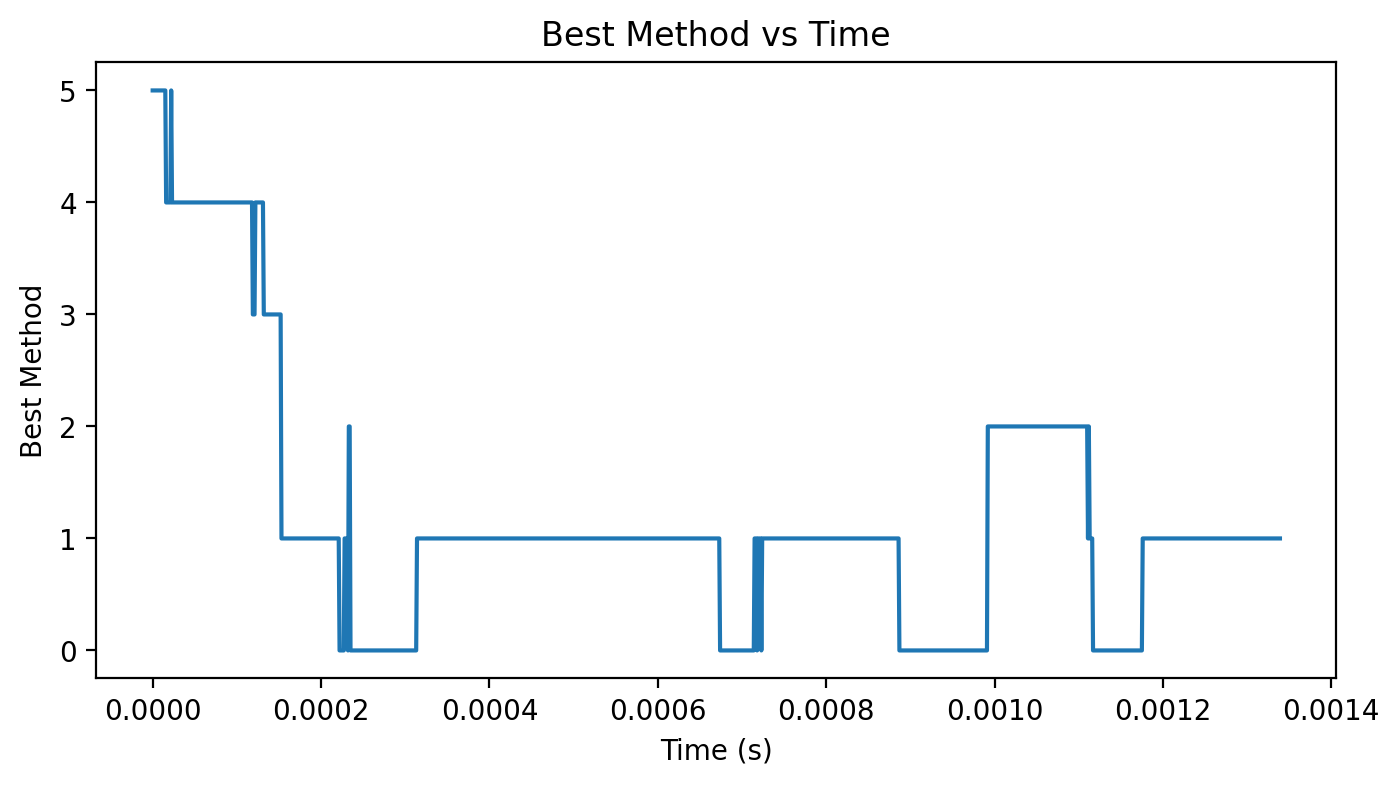

In [52]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=200)
ax.plot(solver_data['time'], solver_data['best_method'])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Best Method')
ax.set_title('Best Method vs Time')
plt.show()

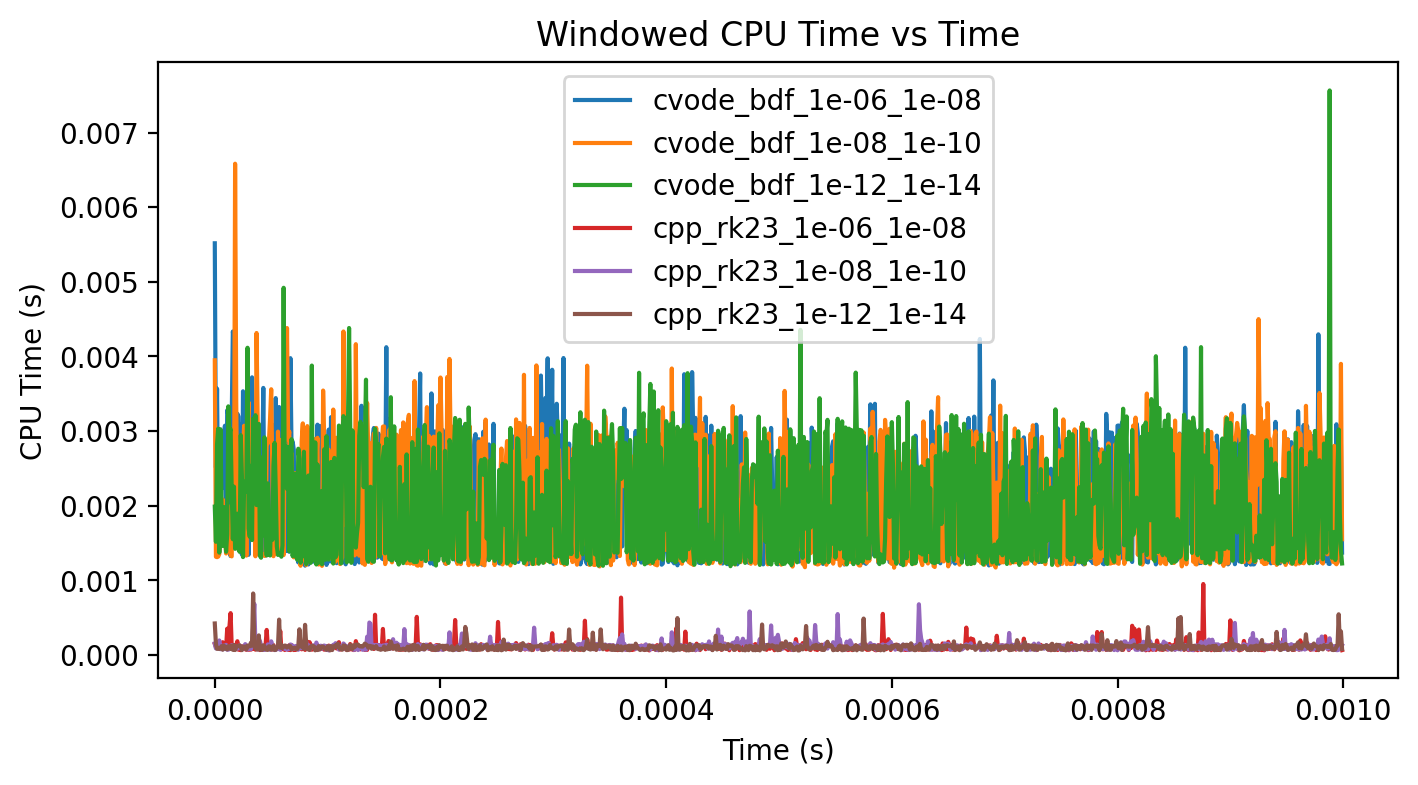

In [106]:
# plot the windowed cpu times vs time for each method and tolerance
fig, ax = plt.subplots(figsize=(8, 4), dpi=200)
for method in methods:
    for tolerance in tolerances:
        method_name = f"{method}_{tolerance[0]}_{tolerance[1]}"
        table_data = all_data[method_name]
        ax.plot(table_data['times'][0:1000], table_data['cpu_times'][0:1000], label=method_name)
ax.legend()
ax.set_xlabel('Time (s)')
ax.set_ylabel('CPU Time (s)')
ax.set_title('Windowed CPU Time vs Time')
plt.show()

In [109]:
all_data['cvode_bdf_1e-06_1e-08'].head()

times  method  temperatures  cpu_times  windowed_cpu_times  \
0  0.000000     0.0    596.928003   0.005516            0.002373   
1  0.000001     0.0    596.928003   0.002510            0.002373   
2  0.000002     0.0    596.928003   0.003567            0.002373   
3  0.000003     0.0    596.928003   0.001930            0.002373   
4  0.000004     0.0    596.928003   0.001418            0.002373   

   fuel_mass_fractions             h            h2             o        o2  \
0             0.041978  0.000000e+00  0.000000e+00  0.000000e+00  0.223219   
1             0.041978  2.339035e-28  2.369029e-28  3.699610e-30  0.223219   
2             0.041978  3.601097e-28  5.191651e-28  7.383293e-30  0.223219   
3             0.041978  4.253095e-28  8.277311e-28  1.058121e-29  0.223219   
4             0.041978  4.608963e-28  1.152515e-27  1.315436e-29  0.223219   

            h2o           ho2          h2o2            oh  
0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
1  1.470799e-22  7.422450e-18  6.485579e-23  1.221454e-23  
2  4.261974e-22  1.484501e-17  1.603345e-22  3.012870e-23  
3  8.465671e-22  2.226765e-17  2.833942e-22  5.314960e-23  
4  1.420417e-21  2.969036e-17  4.327948e-22  8.103525e-23

In [110]:
all_data.keys()

dict_keys(['cvode_bdf_1e-06_1e-08', 'cvode_bdf_1e-08_1e-10', 'cvode_bdf_1e-12_1e-14', 'cpp_rk23_1e-06_1e-08', 'cpp_rk23_1e-08_1e-10', 'cpp_rk23_1e-12_1e-14'])

In [126]:
reference_name = 'cvode_bdf_1e-12_1e-14'
reference_data = all_data[reference_name].copy()

# Create empty DataFrame with same index as reference data
integrator_ranks = pd.DataFrame(index=reference_data.index)

# Add columns for rankings
integrator_ranks['time'] = reference_data['times']
integrator_ranks['best_method'] = pd.Series(dtype=str)

# For each timestep, rank methods by CPU time
for i, t in enumerate(reference_data['times'][:-1]):  # Skip last timestep since we compare with next
    # Get CPU time for each method at this timestep
    method_times = []
    for method in all_data.keys():
        results = all_data[method]
        method_times.append((results['method'][i], results['windowed_cpu_times'][i]))
    
    # Sort methods by CPU time
    ranked_methods = sorted(method_times, key=lambda x: x[1])
    
    # Store best method
    integrator_ranks.at[i, 'best_method'] = ranked_methods[0][0]

# add the temperature, fuel mass fraction, and species fractions to the integrator_ranks
integrator_ranks['temperature'] = reference_data['temperatures']
integrator_ranks['fuel_mass_fraction'] = reference_data['fuel_mass_fractions']
for species in species_to_track:
    integrator_ranks[species] = reference_data[species]



In [124]:
method_times

[(np.float64(0.0), np.float64(0.0018860721588134766)),
 (np.float64(1.0), np.float64(0.0020682954788208007)),
 (np.float64(2.0), np.float64(0.0019464993476867676)),
 (np.float64(3.0), np.float64(0.00014744281768798827)),
 (np.float64(4.0), np.float64(0.0001465177536010742)),
 (np.float64(5.0), np.float64(0.00010240316390991211))]

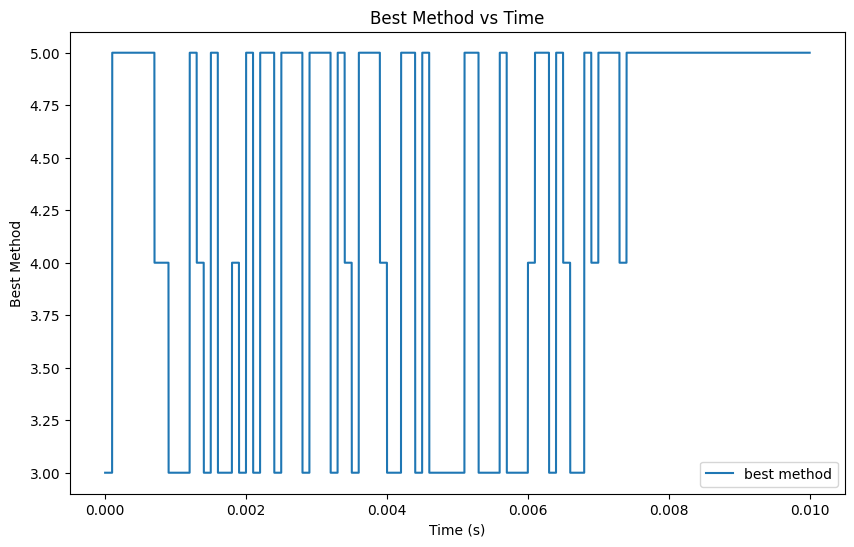

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [ ]:
# plot the best method vs time
plt.figure(figsize=(10, 6))
plt.plot(integrator_ranks['time'], integrator_ranks['best_method'], label='best method')
plt.xlabel('Time (s)')
plt.ylabel('Best Method')
plt.title('Best Method vs Time')
plt.legend()
plt.show()

# plot the best method vs temperature
plt.figure(figsize=(10, 6))

In [127]:
integrator_ranks.head()

time best_method  temperature  fuel_mass_fraction             h  \
0  0.000000         3.0   596.928003            0.041978  0.000000e+00   
1  0.000001         3.0   596.928003            0.041978  2.339035e-28   
2  0.000002         3.0   596.928003            0.041978  3.601097e-28   
3  0.000003         3.0   596.928003            0.041978  4.253095e-28   
4  0.000004         3.0   596.928003            0.041978  4.608963e-28   

             h2             o        o2           h2o           ho2  \
0  0.000000e+00  0.000000e+00  0.223219  0.000000e+00  0.000000e+00   
1  2.369029e-28  3.699610e-30  0.223219  1.470799e-22  7.422450e-18   
2  5.191651e-28  7.383293e-30  0.223219  4.261974e-22  1.484501e-17   
3  8.277311e-28  1.058121e-29  0.223219  8.465671e-22  2.226765e-17   
4  1.152515e-27  1.315436e-29  0.223219  1.420417e-21  2.969036e-17   

           h2o2            oh  
0  0.000000e+00  0.000000e+00  
1  6.485579e-23  1.221454e-23  
2  1.603345e-22  3.012870e-23  
3  2.833942e-22  5.314960e-23  
4  4.327948e-22  8.103525e-23

In [107]:
# plot the windowed cpu times vs time for each method and tolerance

def plot_windowed_cpu_times(all_data, methods, tolerances, slice_size=300, title= "Windowed CPU Time vs Time"):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
    for method in methods:
        for tolerance in tolerances:
            method_name = f"{method}_{tolerance[0]}_{tolerance[1]}"
            table_data = all_data[method_name]
            ax.plot(table_data['times'][0:slice_size], table_data['windowed_cpu_times'][0:slice_size], label=method_name)
    ax.legend()
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('CPU Time (s)')
    ax.set_title(title)
    plt.show()

In [108]:
slice_size = 50

all_data_50 = {}
for method_index in range(len(methods)):
    for tolerance_index in range(len(tolerances)):
        table_data = create_results_table(method_index, tolerance_index, 50)
        all_data_50[f"{methods[method_index]}_{tolerances[tolerance_index][0]}_{tolerances[tolerance_index][1]}"] = table_data



all_data_100 = {}
for method_index in range(len(methods)):
    for tolerance_index in range(len(tolerances)):
        table_data = create_results_table(method_index, tolerance_index, 100)
        all_data_100[f"{methods[method_index]}_{tolerances[tolerance_index][0]}_{tolerances[tolerance_index][1]}"] = table_data


all_data_20 = {}
for method_index in range(len(methods)):
    for tolerance_index in range(len(tolerances)):
        table_data = create_results_table(method_index, tolerance_index, 20)
        all_data_20[f"{methods[method_index]}_{tolerances[tolerance_index][0]}_{tolerances[tolerance_index][1]}"] = table_data



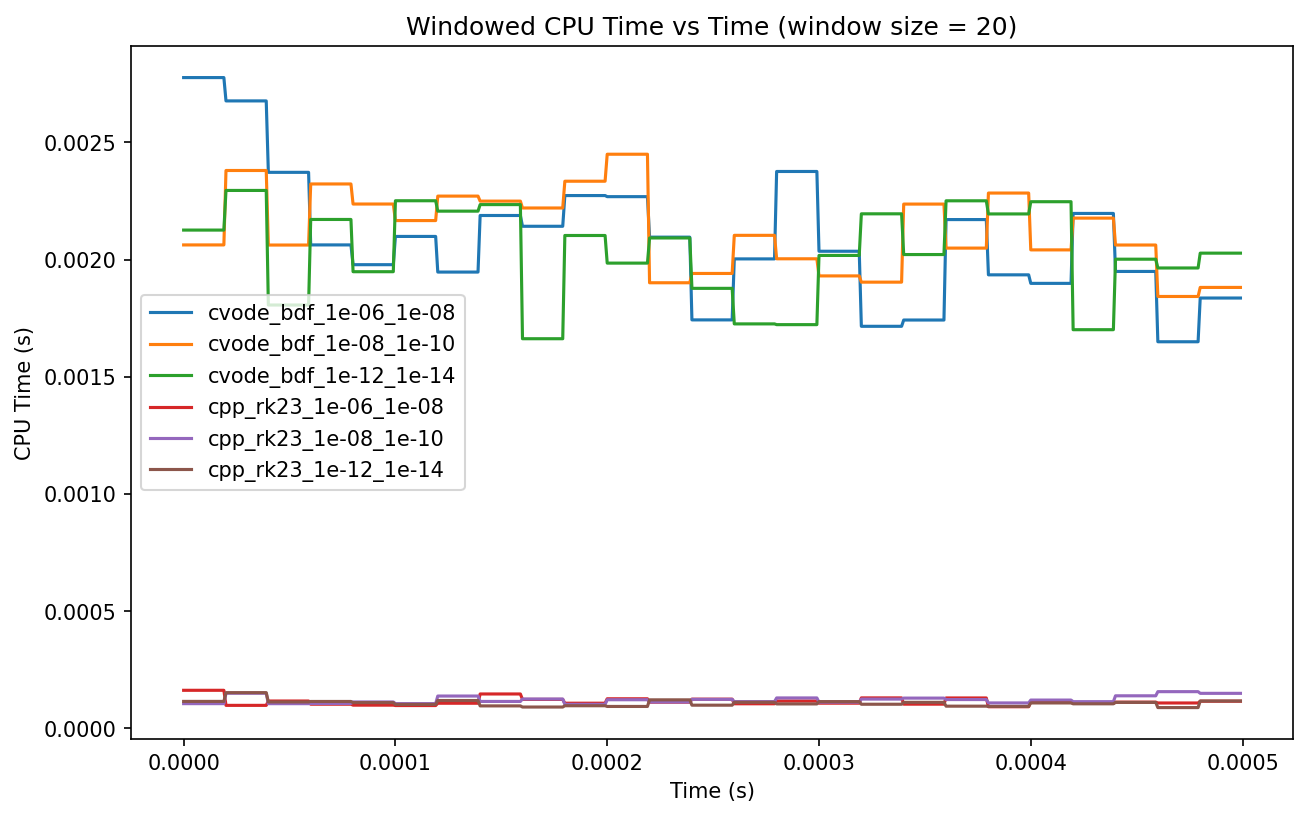

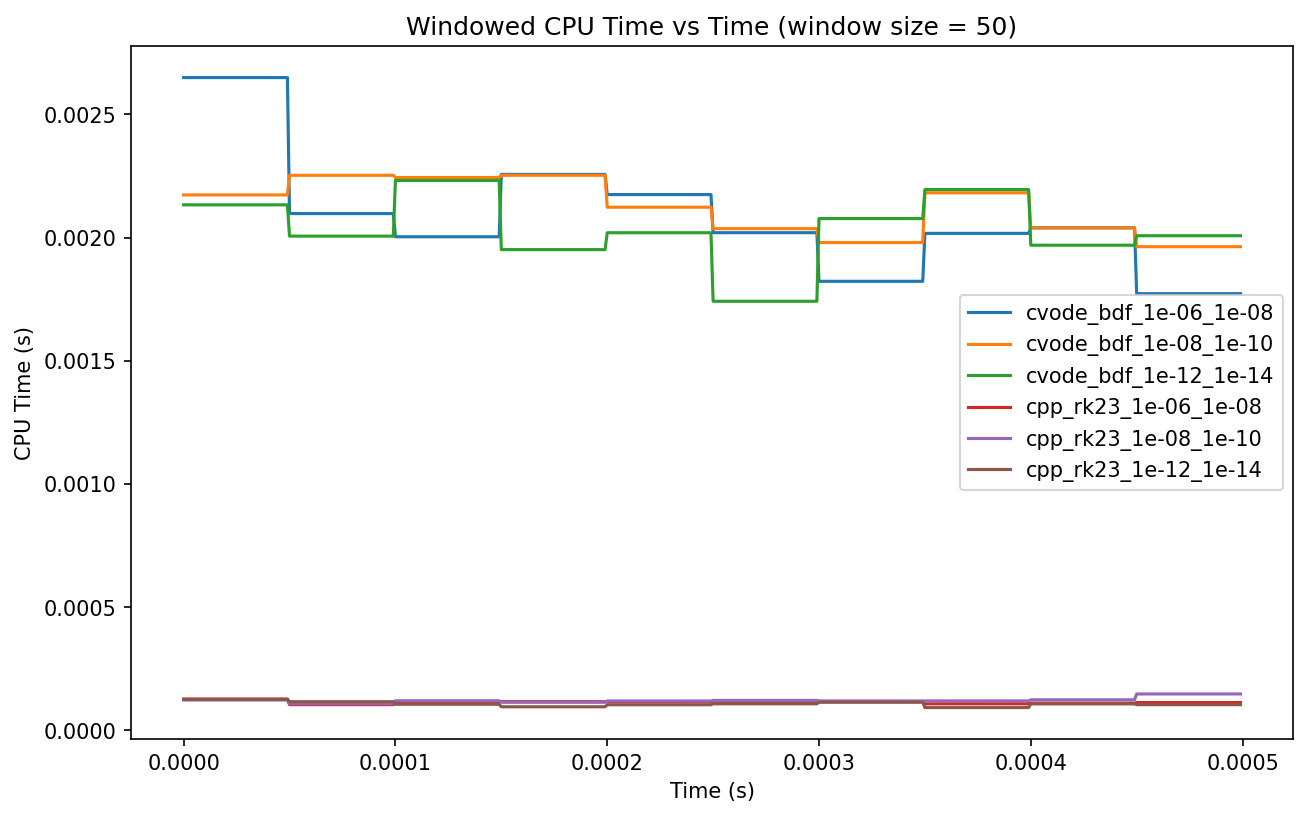

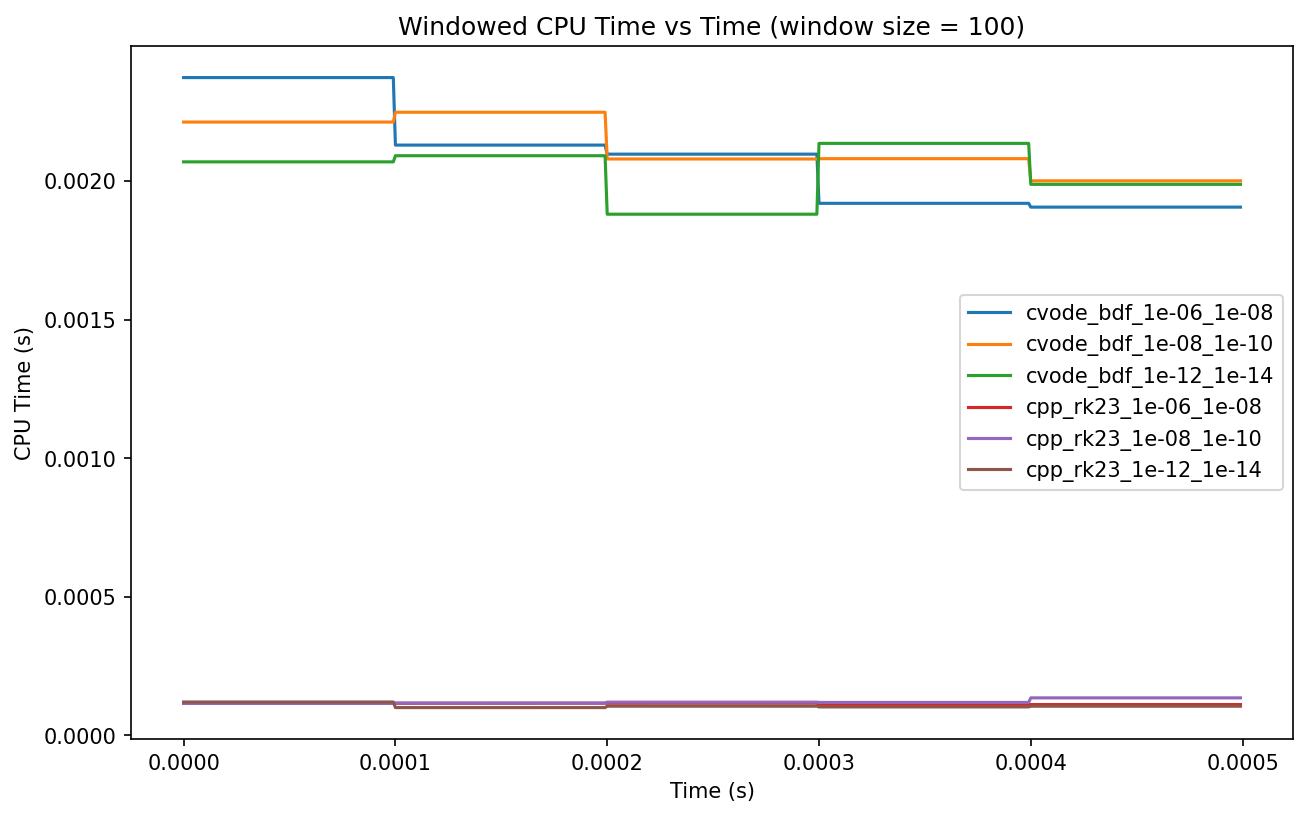

In [91]:
plot_windowed_cpu_times(all_data_20, methods, tolerances, 500, title="Windowed CPU Time vs Time (window size = 20)")
plot_windowed_cpu_times(all_data_50, methods, tolerances, 500, title="Windowed CPU Time vs Time (window size = 50)")
plot_windowed_cpu_times(all_data_100, methods, tolerances, 500, title="Windowed CPU Time vs Time (window size = 100)")

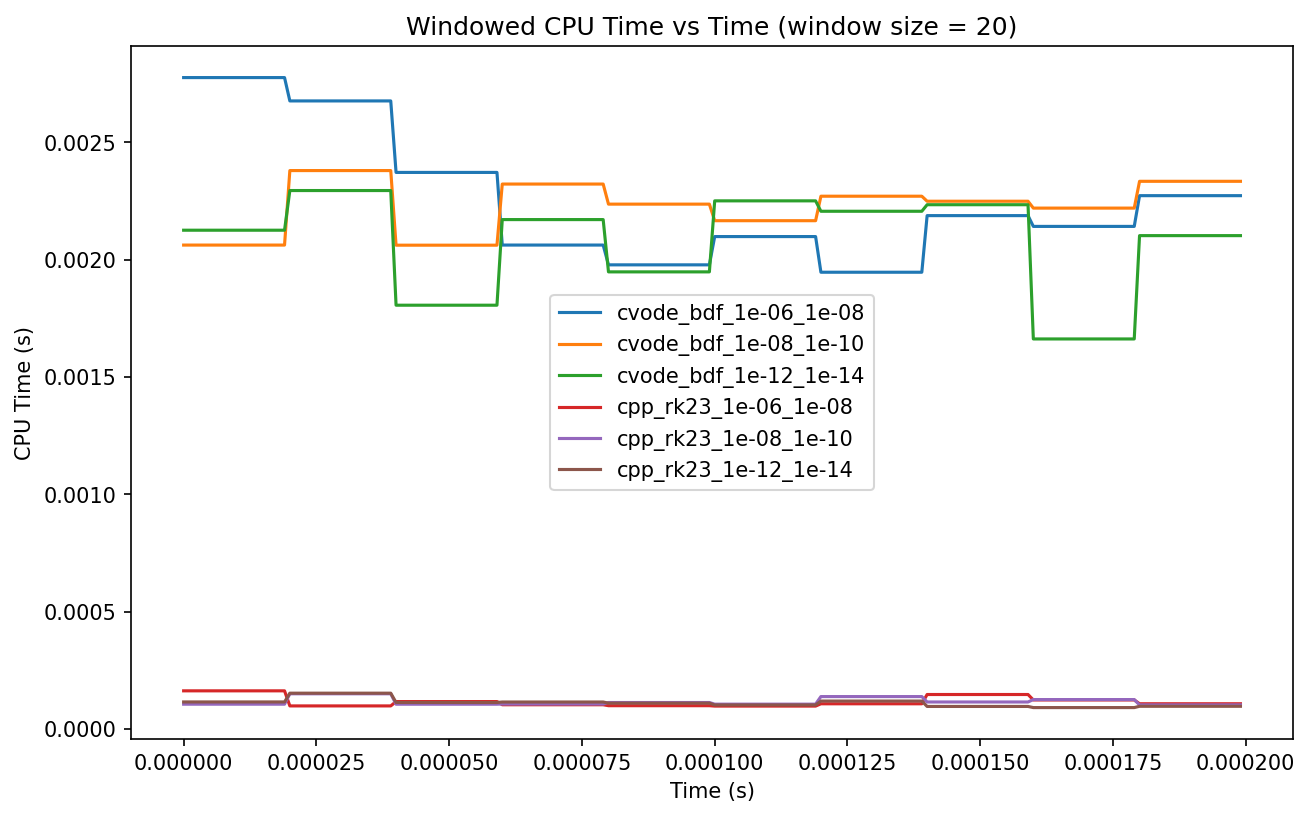

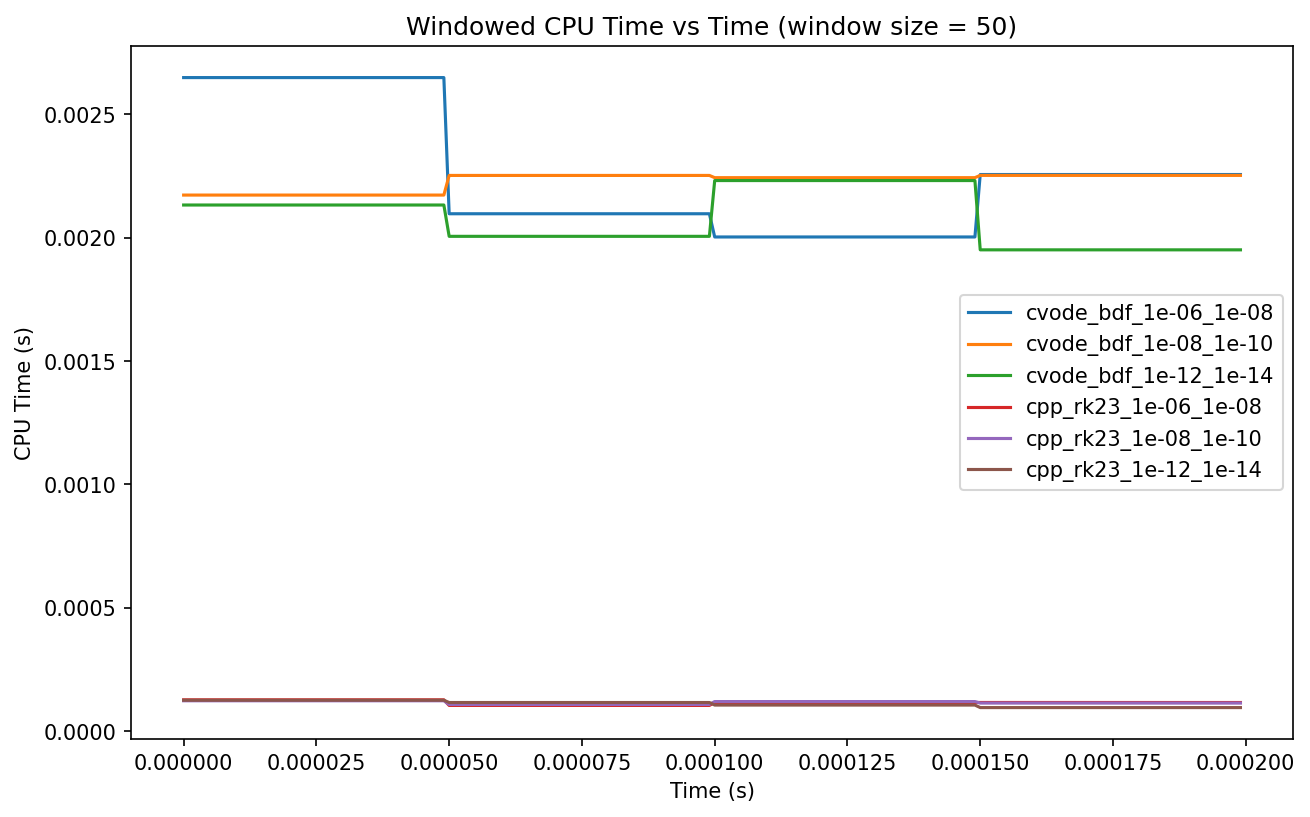

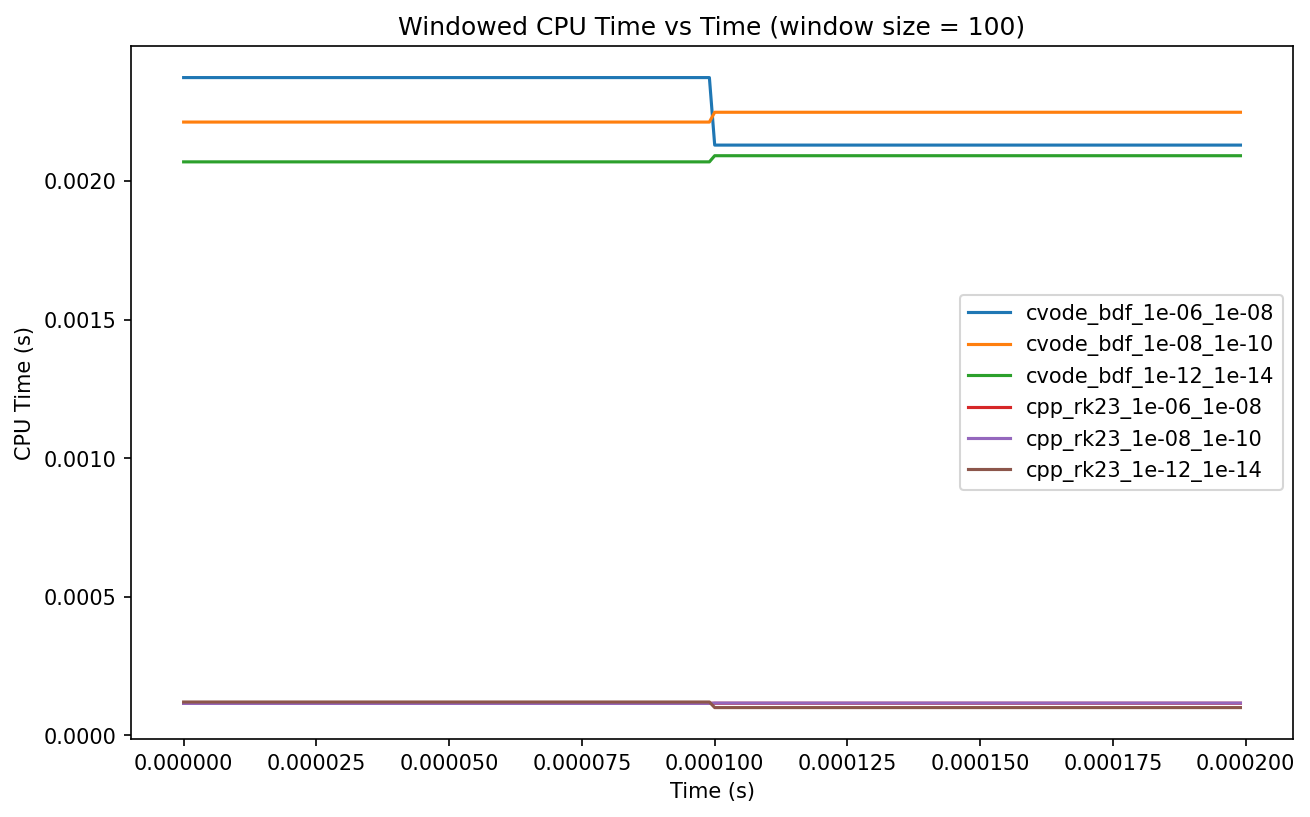

In [92]:
plot_windowed_cpu_times(all_data_20, methods, tolerances, 200, title="Windowed CPU Time vs Time (window size = 20)")
plot_windowed_cpu_times(all_data_50, methods, tolerances, 200, title="Windowed CPU Time vs Time (window size = 50)")
plot_windowed_cpu_times(all_data_100, methods, tolerances, 200, title="Windowed CPU Time vs Time (window size = 100)")

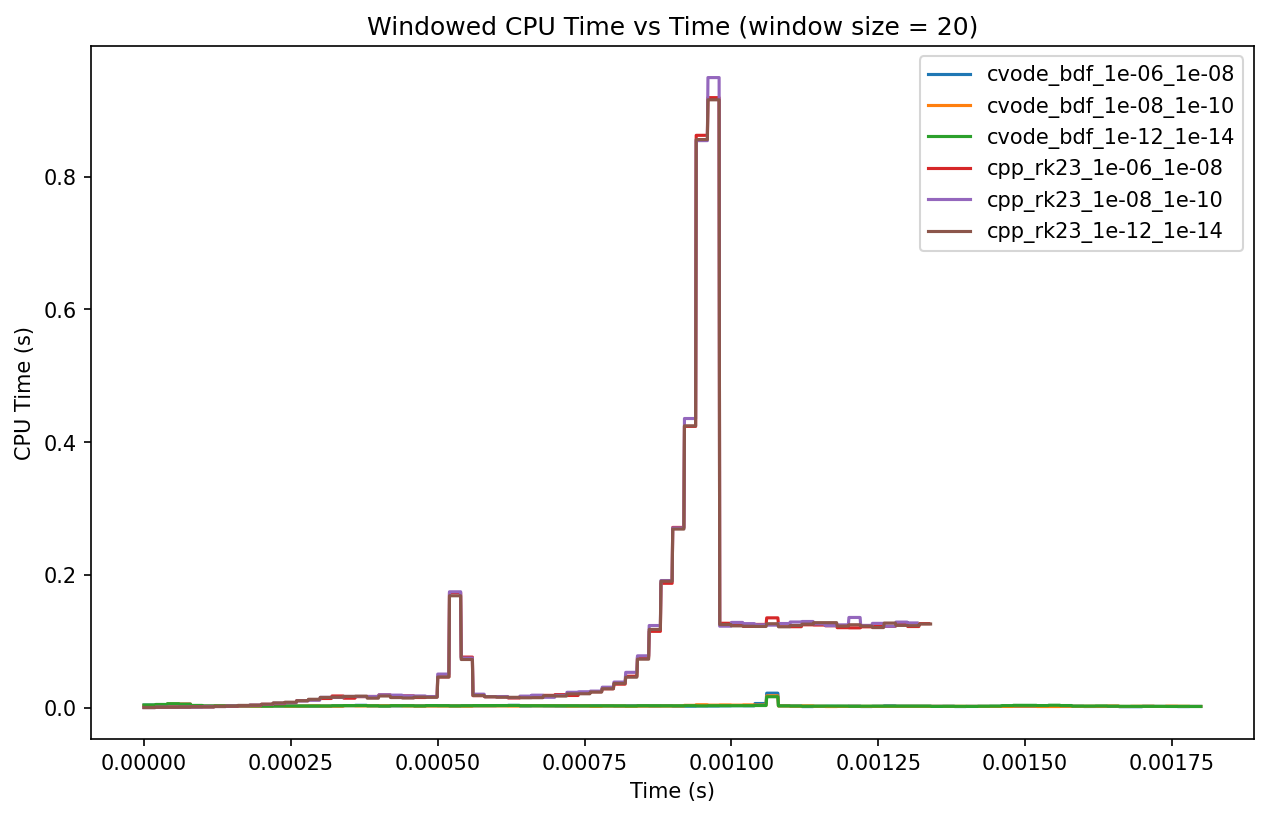

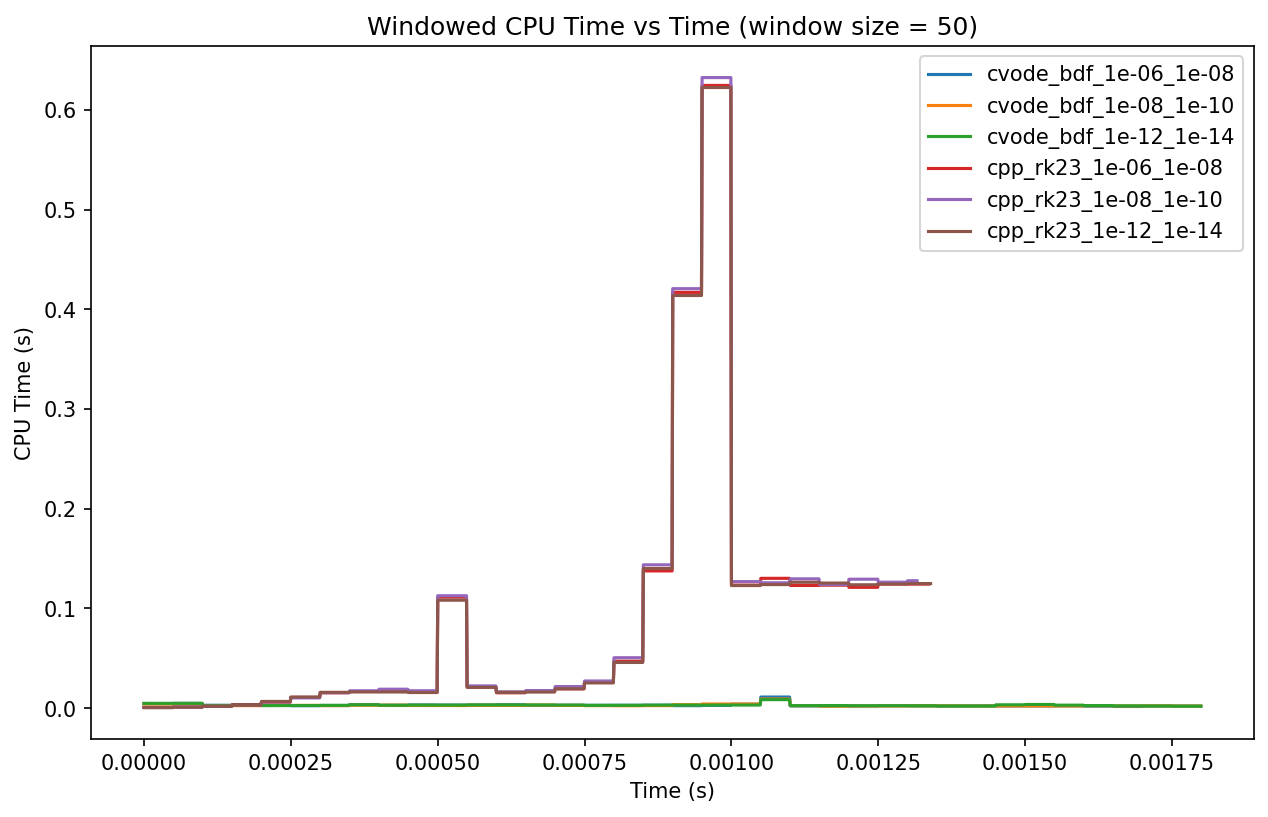

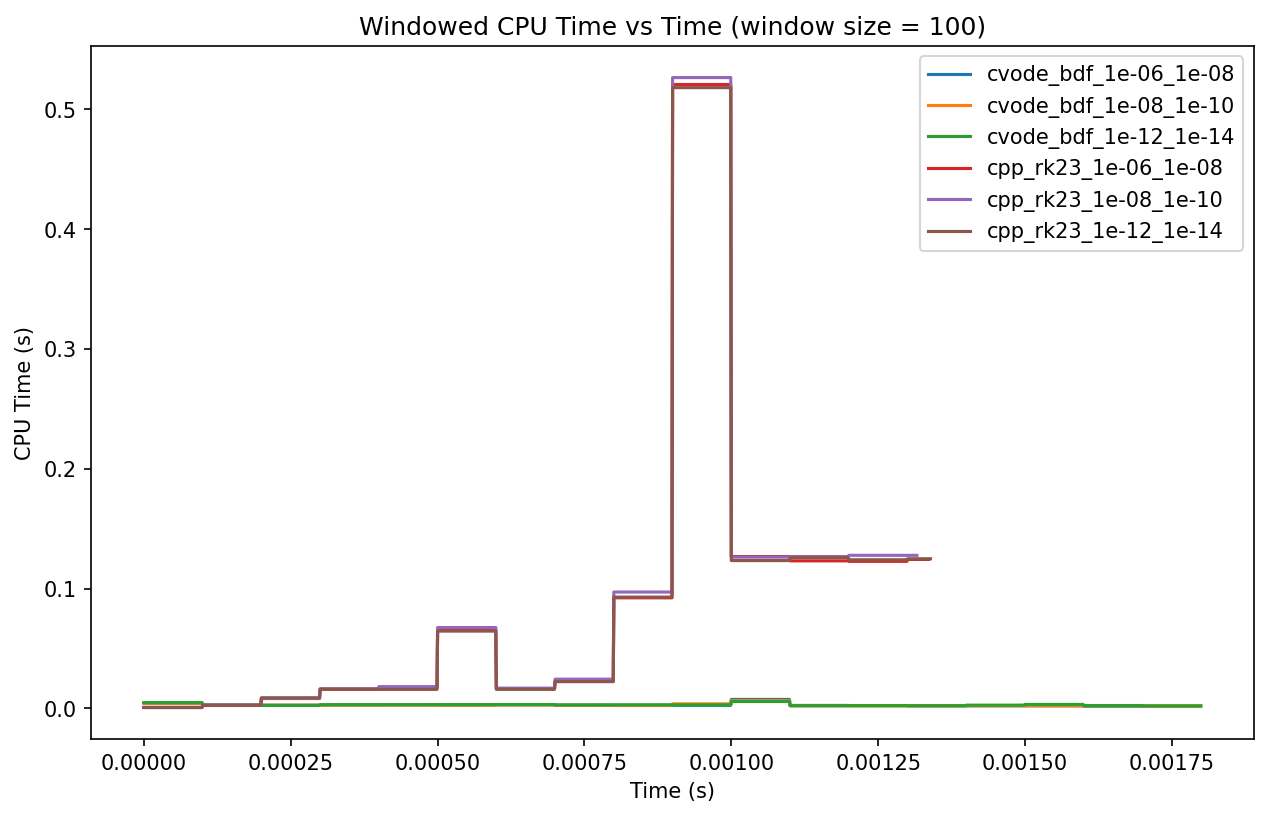

In [83]:
plot_windowed_cpu_times(all_data_20, methods, tolerances, 1800, title="Windowed CPU Time vs Time (window size = 20)")
plot_windowed_cpu_times(all_data_50, methods, tolerances, 1800, title="Windowed CPU Time vs Time (window size = 50)")
plot_windowed_cpu_times(all_data_100, methods, tolerances, 1800, title="Windowed CPU Time vs Time (window size = 100)")

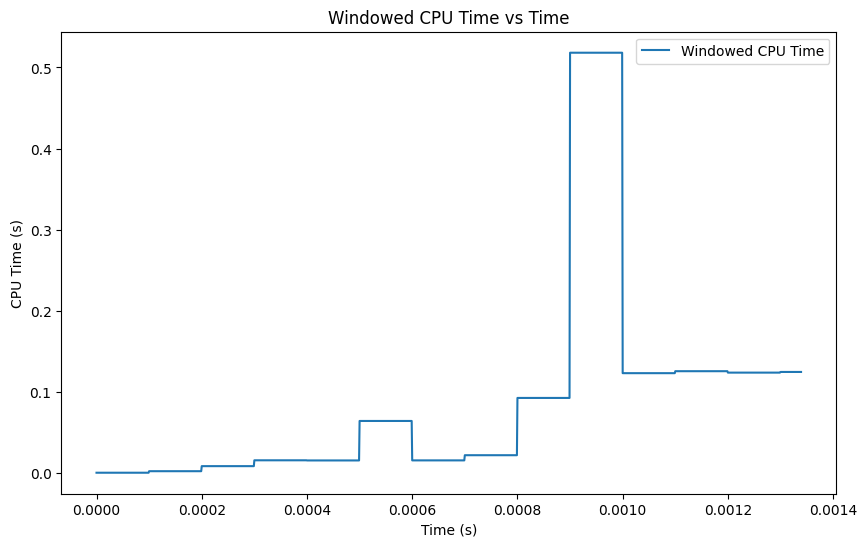

In [59]:
# plot the windowed cpu times vs time
plt.figure(figsize=(10, 6))
plt.plot(table_data['times'], table_data['windowed_cpu_times'], label='Windowed CPU Time')
plt.xlabel('Time (s)')
plt.ylabel('CPU Time (s)')
plt.title('Windowed CPU Time vs Time')
plt.legend()
plt.show()

In [22]:
print(len(results['times']))
print(len(results['temperatures']))
print(len(results['cpu_times']))

1998
1998
1997


In [27]:
results['species_profiles']

{'h': [np.float64(0.0),
  np.float64(1.7021728526416072e-14),
  np.float64(1.9842656391042048e-14),
  np.float64(2.0764016845682816e-14),
  np.float64(2.190144034984336e-14),
  np.float64(2.2486500889900507e-14),
  np.float64(2.3341571521993738e-14),
  np.float64(2.425183771092774e-14),
  np.float64(2.5210698605280838e-14),
  np.float64(2.6211517642797333e-14),
  np.float64(2.7246438829194532e-14),
  np.float64(2.8308624647897065e-14),
  np.float64(2.937065206877351e-14),
  np.float64(3.045606141838286e-14),
  np.float64(3.1558522035110995e-14),
  np.float64(3.26754615584403e-14),
  np.float64(3.3807603702280227e-14),
  np.float64(3.495473322512253e-14),
  np.float64(3.6116050206691124e-14),
  np.float64(3.7292444336781835e-14),
  np.float64(3.848458162642551e-14),
  np.float64(3.9692424976588506e-14),
  np.float64(4.0917255407897305e-14),
  np.float64(4.2158861711591844e-14),
  np.float64(4.379147379048241e-14),
  np.float64(4.473750299415557e-14),
  np.float64(4.602670432378275e-14),

In [23]:
results['steps']

1997

In [27]:
pdf_file_name = "results_20250814_173434/nc12h26_960.0_100000.0__1.3_integrator_ranks.csv"

pickle_file_name = "results_20250814_173434/nc12h26_960.0_100000.0__1.3_results.pkl"

with open(pickle_file_name, 'rb') as f:
    all_results = pickle.load(f)

df = pd.read_csv(pdf_file_name)

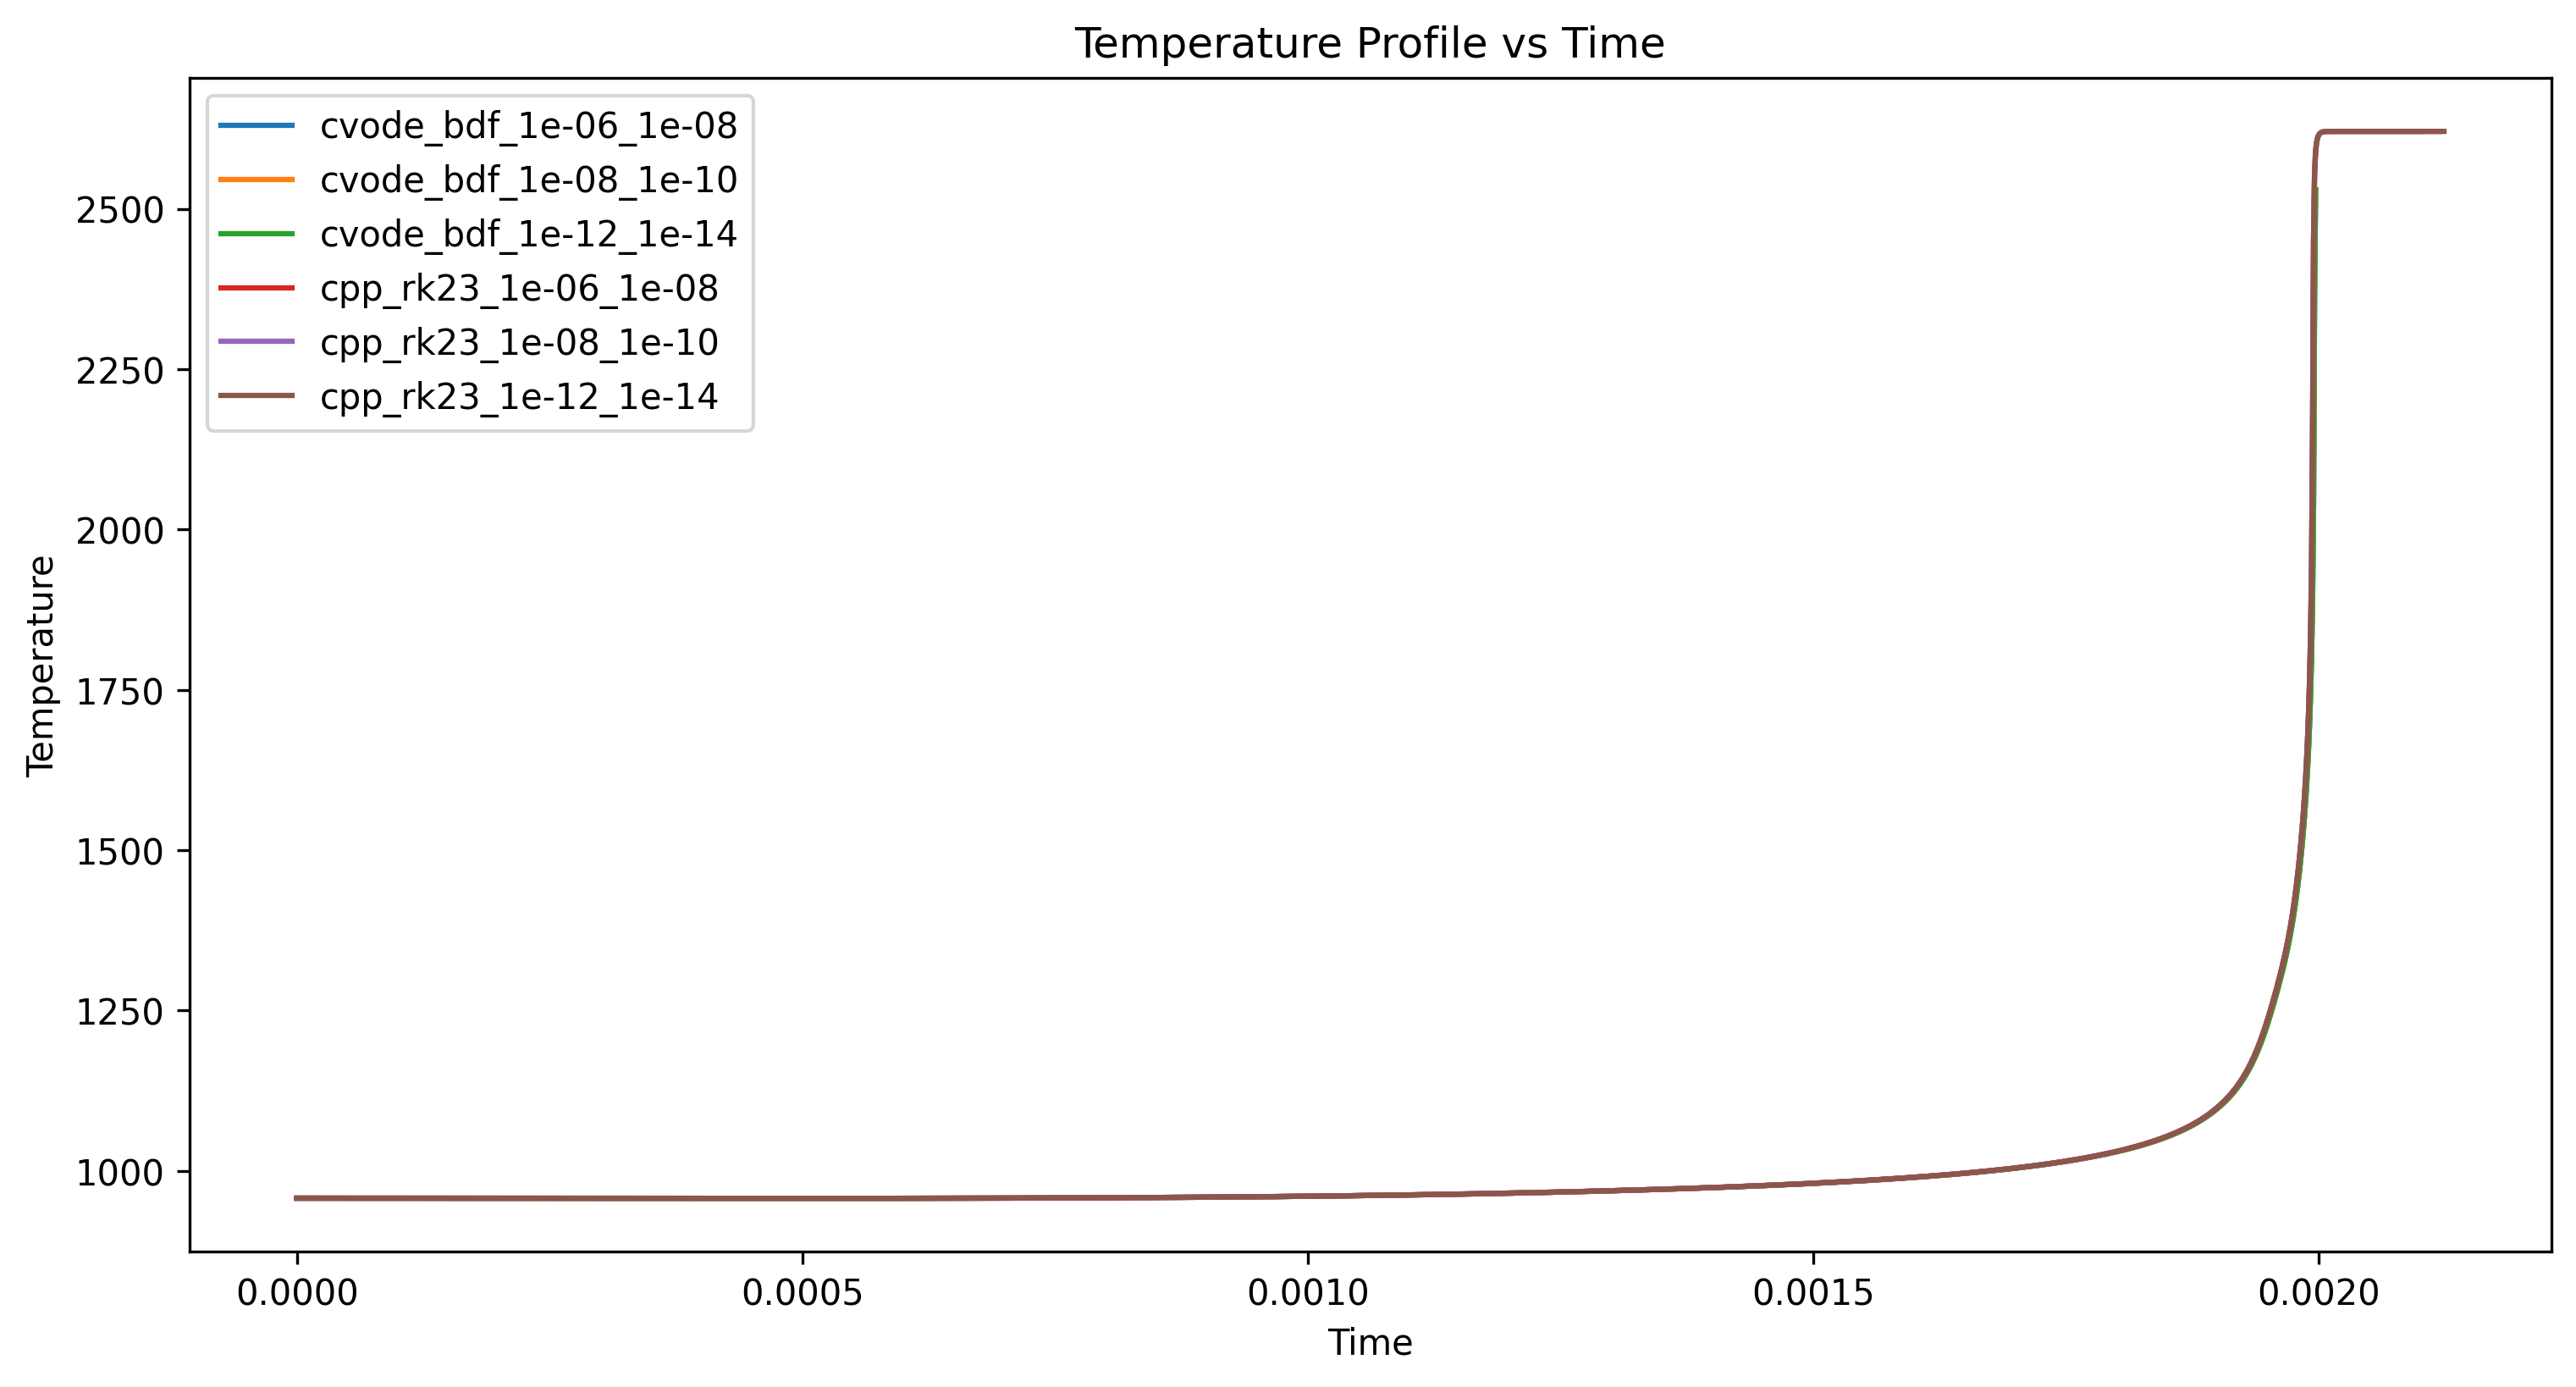

In [28]:
# plot the temperature profile vs time for all the methods and tolerances
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)
for method in methods_to_plot:
    for tolerance in tolerances_to_plot:
        rtol = tolerance[0]
        atol = tolerance[1]
        name = f"{method}_{rtol}_{atol}"
        results = all_results[name]
        ax.plot(results['times'], results['temperatures'], label=f"{method}_{rtol}_{atol}")
ax.set_xlabel('Time')
ax.set_ylabel('Temperature')
ax.set_title('Temperature Profile vs Time')
ax.legend()
plt.show()

/tmp/ipykernel_686886/3652410636.py:9: RuntimeWarning: divide by zero encountered in log10
  ax.plot(results['times'], np.log10(results['species_profiles'][specie]), label=f"{method}_{rtol}_{atol}")
/tmp/ipykernel_686886/3652410636.py:9: RuntimeWarning: invalid value encountered in log10
  ax.plot(results['times'], np.log10(results['species_profiles'][specie]), label=f"{method}_{rtol}_{atol}")


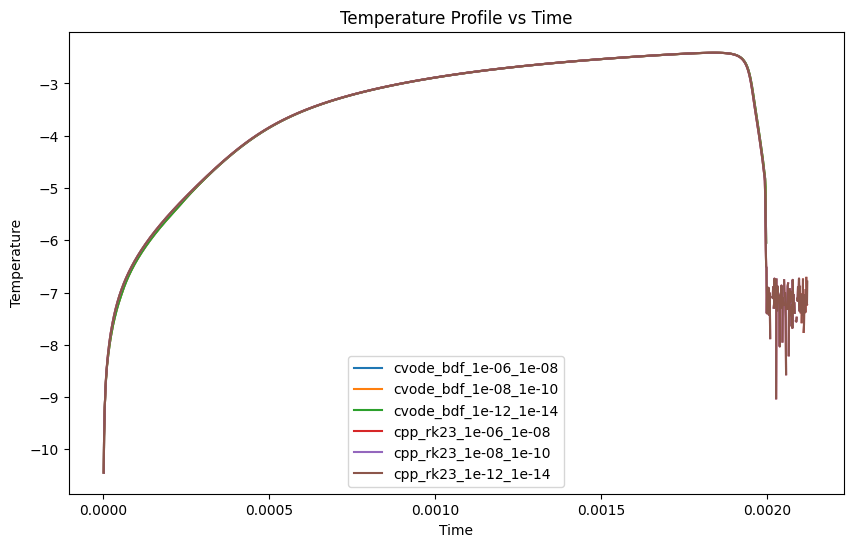

In [29]:
specie = 'h2o2'
fig, ax = plt.subplots(figsize=(10, 6),)
for method in methods_to_plot:
    for tolerance in tolerances_to_plot:
        rtol = tolerance[0]
        atol = tolerance[1]
        name = f"{method}_{rtol}_{atol}"
        results = all_results[name]
        ax.plot(results['times'], np.log10(results['species_profiles'][specie]), label=f"{method}_{rtol}_{atol}")
ax.set_xlabel('Time')
ax.set_ylabel('Temperature')
ax.set_title('Temperature Profile vs Time')
ax.legend()
plt.show()

In [21]:
df.head()

Unnamed: 0      time                 rank1                 rank2  \
0           0  0.000000  cpp_rk23_1e-06_1e-08  cpp_rk23_1e-08_1e-10   
1           1  0.000001  cpp_rk23_1e-06_1e-08  cpp_rk23_1e-12_1e-14   
2           2  0.000002  cpp_rk23_1e-06_1e-08  cpp_rk23_1e-12_1e-14   
3           3  0.000003  cpp_rk23_1e-12_1e-14  cpp_rk23_1e-08_1e-10   
4           4  0.000004  cpp_rk23_1e-12_1e-14  cpp_rk23_1e-08_1e-10   

                   rank3                  rank4                  rank5  \
0   cpp_rk23_1e-12_1e-14  cvode_bdf_1e-12_1e-14  cvode_bdf_1e-08_1e-10   
1   cpp_rk23_1e-08_1e-10  cvode_bdf_1e-08_1e-10  cvode_bdf_1e-12_1e-14   
2   cpp_rk23_1e-08_1e-10  cvode_bdf_1e-08_1e-10  cvode_bdf_1e-12_1e-14   
3  cvode_bdf_1e-12_1e-14  cvode_bdf_1e-08_1e-10   cpp_rk23_1e-06_1e-08   
4   cpp_rk23_1e-06_1e-08  cvode_bdf_1e-12_1e-14  cvode_bdf_1e-08_1e-10   

                          rank6                         rank7  \
0         cvode_bdf_1e-06_1e-08  scipy_lsoda_none_1e-08_1e-10   
1         cvode_bdf_1e-06_1e-08  scipy_lsoda_none_1e-08_1e-10   
2         cvode_bdf_1e-06_1e-08  scipy_lsoda_none_1e-06_1e-08   
3  scipy_lsoda_none_1e-12_1e-14         cvode_bdf_1e-06_1e-08   
4         cvode_bdf_1e-06_1e-08  scipy_lsoda_none_1e-12_1e-14   

                          rank8                         rank9  
0  scipy_lsoda_none_1e-12_1e-14  scipy_lsoda_none_1e-06_1e-08  
1  scipy_lsoda_none_1e-06_1e-08  scipy_lsoda_none_1e-12_1e-14  
2  scipy_lsoda_none_1e-08_1e-10  scipy_lsoda_none_1e-12_1e-14  
3  scipy_lsoda_none_1e-08_1e-10  scipy_lsoda_none_1e-06_1e-08  
4  scipy_lsoda_none_1e-08_1e-10  scipy_lsoda_none_1e-06_1e-08

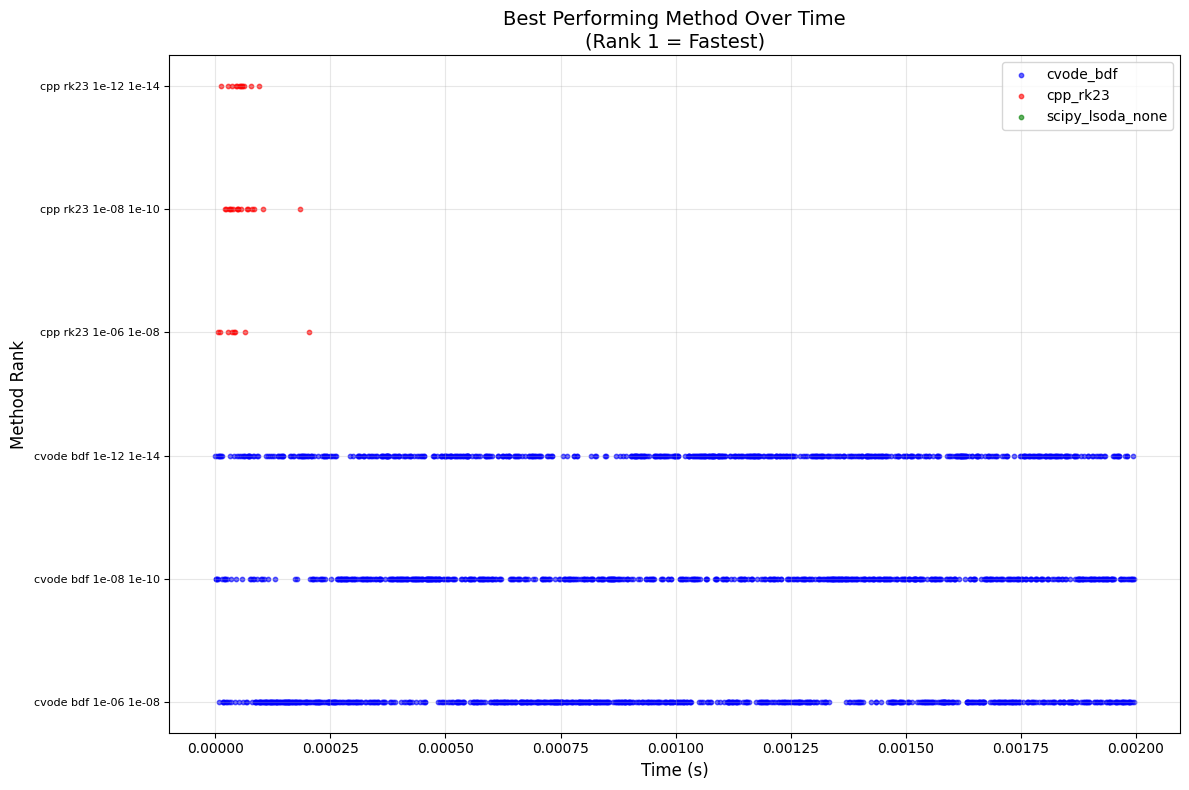

In [26]:
# Plot rank 1 vs time with color-coded integrators
import matplotlib.pyplot as plt
import pandas as pd

integrator_ranks_ = df.copy()

method_to_number = {}
method_colors = {
    'cvode_bdf': 'blue',
    'cpp_rk23': 'red', 
    'scipy_lsoda_none': 'green'
}

counter = 0
for method in methods_to_plot:
    for tolerance in tolerances_to_plot:
        rtol = tolerance[0]
        atol = tolerance[1]
        name = f"{method}_{rtol}_{atol}"
        method_to_number[name] = counter
        counter += 1

# Create a new column with method numbers
integrator_ranks_['rank1num'] = [method_to_number[method] if method in method_to_number else float('nan') for method in integrator_ranks_['rank1']]

fig, ax = plt.subplots(figsize=(12, 8))

# Plot each integrator separately with its own color and label
for base_method in method_colors:
    mask = integrator_ranks_['rank1'].str.startswith(base_method)
    if mask.any():
        ax.scatter(
            integrator_ranks_[mask]['time'], 
            integrator_ranks_[mask]['rank1num'],
            c=method_colors[base_method],
            label=base_method,
            alpha=0.6,
            s=10
        )

ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Method Rank', fontsize=12) 
ax.set_title('Best Performing Method Over Time\n(Rank 1 = Fastest)', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)

# Add y-axis labels showing method names
yticks = list(method_to_number.values())
ytick_labels = [name.replace('_', ' ') for name in method_to_number.keys()]
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels, fontsize=8)

plt.tight_layout()
plt.show()